# Entropy Mapping

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import geopandas as gpd
from shapely import Point
from scipy.ndimage.filters import gaussian_filter
import contextily as ctx
from shapely.geometry import Polygon
import os
%matplotlib widget

C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\3154988767.py:8: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [42]:
# Some variables to declare and modify based on user preferences

# Time/Bin length
binLength = 900 #By default, BEAMCORE outputs time in seconds, so for hour-length bins use 3600
minParkTime = 300

# mainDirectory  = '/Users/cpoliziani/Downloads/entropyCalc/'#In my case I have the codes in a directory and the images are in a sub-directory
mainDirectory = 'C:\\Users\\jmckinney\\ForReadingData\\' #I just added this because this is what works on Jack's PC

# zoningFilepath = 'BlockIDS/geo_export_2642a579-6c47-479f-b94c-0d5f27ccb433.shp'
# zoningFilepath = 'Grids/grid1000.shp'
zoningFilepath1 = 'Grids\\grid500.shp'
zoningFilepath2 = 'Grids\\grid1000.shp'
zoningFilepath3 = 'Grids\\grid5000.shp'
zoningFilepath4 = 'Grids\\grid10000.shp'

#File paths for varying bin lengths
binFilepath1 = 'binadjustedcsv\\elecCarTrace600.csv'
binFilepath2 = 'binadjustedcsv\\elecCarTrace900.csv'
binFilepath3 = 'binadjustedcsv\\elecCarTrace1800.csv'
binFilepath4 = 'binadjustedcsv\\elecCarTrace3600.csv'
binFilepath5 = 'binadjustedcsv\\elecCarTrace7200.csv'

# Parameters that could be prompted or automated depending on the scenario
startHour = 72000
endHour = 86400

# Inputs for the grid creation (you can easily change these)
xmin = -13755000 # X min boundary
xmax = -13485000# X max boundary
ymin = 4420000    # Y min boundary
ymax = 4705000  # Y max boundary
grid_size = 500 # Grid size in meters (1km)
gridName = 'grid' + str(grid_size)

In [52]:
#CP I've put all the functions here at the beginning
def create_grid(xmin, xmax, ymin, ymax, grid_size, crs="EPSG:3857", output_file="grid.shp"):
    # Generate the coordinates for the grid
    x_coords = np.arange(xmin, xmax, grid_size)
    y_coords = np.arange(ymin, ymax, grid_size)

    # Create polygons for each grid cell
    polygons = []
    for x in x_coords:
        for y in y_coords:
            # Define the polygon corners
            poly = Polygon([(x, y), (x + grid_size, y), 
                            (x + grid_size, y + grid_size), (x, y + grid_size)])
            polygons.append(poly)

    # Create a GeoDataFrame with the grid polygons
    grid = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)
    
    grid['geoid'] = range(len(grid))
    
    # Save the grid to a shapefile
    grid.to_file(output_file)
    return grid
    
def parkingTimecol(df):
    """
    Calculate the parking time for each vehicle trip in the DataFrame.

    Parameters:
    df: A DataFrame containing daily vehicle information, including
                       'vehicle', 'departureTime', and 'arrivalTime' columns.

    Returns:
    A new DataFrame with an additional column 'Parking Time' 
                  representing the total parking time for each vehicle.
    """
    vehicleList = df['vehicle'].unique()
    column = []
    for item in vehicleList:
        subdf = df.loc[df['vehicle'] == item].copy() 
        subdf = subdf.sort_values(by = 'departureTime', ignore_index = True)
        firstDepart = subdf['departureTime'].iloc[0]
        subdf['departureTime'] = subdf['departureTime'].shift(-1) 
        subdf.loc[subdf.index[-1], 'departureTime'] = firstDepart + 24 * 3600  
        subdf.loc[:, 'Parking Time'] = subdf['departureTime'] - subdf['arrivalTime'] 
        column.append(subdf)
    return pd.concat(column)  

def travelLengthCol(df):
    """
    Calculate the daily cumulative travel length for each vehicle trip in the DataFrame.

    Parameters:
    df: A DataFrame containing vehicle information, including
                       'vehicle' and 'length' columns.

    Returns:
    A new DataFrame with an additional column 'Cumulative Travel Length' 
                  representing the total distance traveled by each vehicle.
    """
    vehicleList = df['vehicle'].unique()
    distanceTraveled = []
    for item in vehicleList:
        subdf = df.loc[df['vehicle'] == item].copy() 
        subdf = subdf.sort_values(by = 'departureTime', ignore_index = True)
        subdf.loc[:, 'Cumulative Travel Length'] = subdf['length'].cumsum()  
        distanceTraveled.append(subdf)
    return pd.concat(distanceTraveled) 

def timeCorrecter(df, binSize):
    """
    Transform Parking time column into a list of parking times per time bin
    Time bins start from 0 and advance by binLength
    
    """
    listoflists = []
    for index, row in df.iterrows():
        listalike = []
        parkResult = divmod(row['Parking Time'], binSize)
        arriveResult = divmod(row['arrivalTime'], binSize)
        i = 0
        while i < parkResult[0]:
            listalike.append(binSize)
            i += 1
        listalike.append(parkResult[1])
        listalike[0] = listalike[0] - arriveResult[1]
        listalike[-1] = listalike[-1] + arriveResult[1]
        if listalike[-1] > binSize:
            listalike[-1] = listalike[-1] - binSize
            listalike.insert(-1, binSize)
        listoflists.append(listalike)
    return listoflists

#JM added the final data sorting as a function to make the multiplot process easier to control
def scenarioCreator(binLength, gridSize):
    #df = pd.read_csv(mainDirectory + 'elecCarTrace2.csv') 
    df = PTs2.copy()
    binLabel = np.divmod(df['arrivalTime'], binLength)
    df['Bin Label'] = binLabel[0]
    # Transfor the parking time column in lists of parking times per bin
    df['Parking Time'] = timeCorrecter(df, binSize = binLength)
    df = df.sort_values(by=['vehicle', 'departureTime'], ignore_index=True)
    def assign_sequence(lst):  
        return [(i, val) for i, val in enumerate(lst)]  # (sequence_number, value)

    # Apply the function to 'Parking Time' to associate a sequence number
    df['Parking Time'] = df['Parking Time'].apply(assign_sequence)

    # Separate the sequence number and the 'Parking Time' into two columns
    df = df.explode('Parking Time')
    df['sequence_number'], df['Parking Time'] = zip(*df['Parking Time'])
    df['Bin Label'] += df['sequence_number']
    # Optionally reset the index if needed and sort if necessary
    df.reset_index(drop=True, inplace=True)

    #Transfor Bin column into actual time in seconds
    df['Bin Label'] = df['Bin Label'] * binLength

    #Calculate Charging Opportunity
    df['Charging Opportunity'] = (df['Parking Time'] * df['Cumulative Travel Length'])/binLength
    df['Charging Opportunity'] = df['Charging Opportunity'].astype(float)

    #Add up time bins from the second day to the first day
    df.loc[df['Bin Label'] >= 24*3600 , 'Bin Label'] -= 24 *3600
    #print('Total Chargin Opportunities Entries:', len(elecCarTrace))
    df = df[df['Bin Label']<=24*3600]
    #print('Total Chargin Opportunities Entries after filtering people departing for the first time after midnight:', len(elecCarTrace))

    #Add block group info and normalize by area
    df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['endX'], df['endY']))
    df = df.set_crs(epsg=4326)
    df = df.to_crs(epsg=3857)
    #block_groups_gdf = gpd.read_file(zoningFilepath)[['geoid','geometry']]
    block_groups_gdf = gpd.read_file(mainDirectory + gridSize)[['geoid','geometry']]
    #block_groups_gdf = create_grid(xmin, xmax, ymin, ymax, gridSize)
    if block_groups_gdf.crs != df.crs: block_groups_gdf = block_groups_gdf.to_crs(df.crs)
    df = gpd.sjoin(df, block_groups_gdf[['geoid','geometry']], how='left', predicate='within')
    #print('Total Chargin Opportunities Entries with Valid Block Group:', len(elecCarTrace))
    df = df.drop(columns=['geometry'])
    df = df.merge(block_groups_gdf[['geoid','geometry']], how ='left', on = 'geoid')
    df = gpd.GeoDataFrame(df, geometry='geometry')
    df.to_csv(mainDirectory + 'csvFiles\\ectBin' + str(binLength) + 'Gridinsertanumber.csv')
    return df


#CP I'd separate the entropy calculation from the entropy plot functions: have a unique entropy calculation file, and multiple plot functions

def entropyPlot5(result_gdf):
    #CP groupby geoid - might want to groupy by a new variable that you specify at the beginning as an input
    #e.g. groupVariable = 'geoid' or 'link'

    fig, ax = plt.subplots(figsize=(8, 8))
    plt.suptitle('Heatmap of Entropy by Location', y = 0.95)
    plt.title(time)

    img = result_gdf.plot(column = 'Entropy',
                                cmap = 'Reds',
                                ax = ax,
                                legend = True,
                                vmin = 0,
                                vmax = 0.05
                                )
#SF     xlim=(-13650000, -13600000)
#SF     ylim=(4530000, 4570000)    
    xlim=(-13755000, -13485000)
    ylim=(4420000, 4705000)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=10, alpha = 0.4)
    #plt.savefig(mainDirectory + 'images/heatmap' + str(time) +'.png', dpi = 100)
    plt.savefig(mainDirectory + 'images\\heatmap' + str(time) +'.png', dpi = 100)
    plt.show()
    
#Plot Time evolution of entropy and charging opportunity
def entropyPlot6(name):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    scenarioList = ['Scen. 1', 'Scen. 2', 'Scen. 3', 'Scen. 4', 'Scen. 5']

    # Plot total charging opportunity on the first axis
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Total Charging Opportunity', color='tab:blue')
    ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
    ax2.set_ylabel('Total Entropy', color='tab:red')

    # Create a second y-axis for the total entropy
    for opportunity, time, scenario in zip(opportunityResults,labels,scenarioList):
        ax1.plot(time, opportunity, label = 'Charging' + scenario)
        ax1.tick_params(axis='y')

    for entropy, time, scenario in zip(entropyResults,labels,scenarioList):
        ax2.plot(time, entropy, label='Entropy' + scenario, linestyle = '--')
        ax2.tick_params(axis='y')
    # Add a title and display the plot
    plt.title('Temporal Evolution of Total Charging Opportunity and Total Entropy')
    plt.suptitle(name)
    fig.tight_layout()  # To prevent overlap of labels
    fig.legend(loc='lower left')
    plt.savefig(mainDirectory + 'timeEvolutionPlots\\scenarioTimeEvolution' + name + '.png', dpi = 100)
    plt.show()

## Grabbing the BEAM CORE Data

In [4]:
########### Activate only when creating new grids

# Create a grid shapefile
# Inputs for the grid creation (you can easily change these)
xmin = -13755000 # X min boundary
xmax = -13485000# X max boundary
ymin = 4420000    # Y min boundary
ymax = 4705000  # Y max boundary
grid_size = 500# Grid size in meters (1km)
name = 'grid500'
# Call the function to create the grid and save as shapefile
create_grid(xmin, xmax, ymin, ymax, grid_size, crs='EPSG:3857', output_file= mainDirectory+'Grids\\'+gridName+'.shp')

# Read and filter data
events = pd.read_csv('https://storage.googleapis.com/beam-core-outputs/sfbay-tr_capacity_1_5-20230608/beam/year-2020-iteration-4/ITERS/it.0/0.events.csv.gz', 
                     usecols = [
#                          'time',
                                'length',
                                'arrivalTime',
                                'departureTime',
                                'primaryFuelType',
                                'vehicle',
                                'mode',
                                'type', 
#                                 'link',
#                                 'links',
#                                 'linkTravelTime', 
#                                 'startX',
#                                 'startY',
                                'endX',
                                'endY'],
#                     nrows = 10000000 # to have a smaller DF
                    )

#Slicing and merging dataframes
print('Total Events: ', len(events))
PTs = events.loc[events['type'] == 'PathTraversal']
print('Total PathTraversal: ', len(PTs))
PTs = PTs.drop(columns = 'type')

PTs = PTs[PTs['arrivalTime']<104400]
print('Total PathTraversal after filtering Arrival < 5am of Successive Day: ', len(PTs))


print('Simulated PathTraversal Modes: ',PTs['mode'].value_counts())
#More slicing, this time specifically isolating the electric cars in the events files
PTs = PTs.loc[events['mode'].isin(['car',
                                         'car_hov2',
                                         'car_hov3',
#                                          'ride_hail',
#                                          'ride_hail_pooled',
                                        ])]
print('Total Length Car PathTraversal: ', len(PTs))
PTs = PTs.loc[PTs['primaryFuelType'] == 'Electricity']
print('Total Length Electric Car PathTraversal: ', len(PTs))
PTs = PTs.drop(columns = ['mode','primaryFuelType'])

#Sorting the rows by vehicle and then by departure time, making the accumulation sums easier to manage
PTs = PTs.sort_values(by = ['vehicle', 'departureTime'], ignore_index = True)

print('Total Travel Length in km',PTs['length'].sum()/1000)


PTs.to_csv(mainDirectory + 'elecCarTrace.csv')

C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\211507769.py:15: DtypeWarning: Columns (24,25,59) have mixed types. Specify dtype option on import or set low_memory=False.
  events = pd.read_csv('https://storage.googleapis.com/beam-core-outputs/sfbay-tr_capacity_1_5-20230608/beam/year-2020-iteration-4/ITERS/it.0/0.events.csv.gz',


Total Events:  36807426
Total PathTraversal:  8968315
Total PathTraversal after filtering Arrival < 5am of Successive Day:  8955881
Simulated PathTraversal Modes:  mode
walk         4153525
car          2693381
bus          1285026
car_hov2      407358
car_hov3      287333
tram           54929
bike           40360
cable_car      17836
subway         14358
rail            1702
ferry             73
Name: count, dtype: int64
Total Length Car PathTraversal:  3388072
Total Length Electric Car PathTraversal:  11116
Total Travel Length in km 71445.74804699999


## Sorting and Calculating

In [5]:
PTs2 = PTs.copy()
#PTs2 = pd.read_csv(mainDirectory+'elecCarTrace.csv')
# Calculate Parking Time
PTs2 = parkingTimecol(PTs2)
print('Total Parking Time in Hours',PTs2['Parking Time'].sum()/3600)


# Calculate Cumulative Length
PTs2 = travelLengthCol(PTs2)
PTs2 = PTs2.drop(columns = ['length'])

# Calculate Last Link
# elecCarTrace['last_link'] = elecCarTrace['links'].str.split(',').apply(lambda x: x[-1])
# elecCarTrace = elecCarTrace.drop(columns=['links'])

#Filter small parking time and zero lengths
PTs2 = PTs2[PTs2['Parking Time']>minParkTime]

PTs2 = PTs2[PTs2['Cumulative Travel Length']>0]

# Make sure it's still in order
PTs2 = PTs2.sort_values(by=['vehicle', 'departureTime'], ignore_index=True)

PTs2.reset_index(drop = True, inplace = True)

PTs2.to_csv(mainDirectory + 'elecCarTrace2.csv')

Total Parking Time in Hours 30817.54527777778


In [30]:
elecCarTrace = PTs2.copy()

binLabel = np.divmod(elecCarTrace['arrivalTime'], binLength)
elecCarTrace['Bin Label'] = binLabel[0]
# Transfor the parking time column in lists of parking times per bin
elecCarTrace['Parking Time'] = timeCorrecter(elecCarTrace, binSize = binLength)
elecCarTrace = elecCarTrace.sort_values(by=['vehicle', 'departureTime'], ignore_index=True)
def assign_sequence(lst):  
    return [(i, val) for i, val in enumerate(lst)]  # (sequence_number, value)

# Apply the function to 'Parking Time' to associate a sequence number
elecCarTrace['Parking Time'] = elecCarTrace['Parking Time'].apply(assign_sequence)

# Separate the sequence number and the 'Parking Time' into two columns
elecCarTrace = elecCarTrace.explode('Parking Time')
elecCarTrace['sequence_number'], elecCarTrace['Parking Time'] = zip(*elecCarTrace['Parking Time'])
elecCarTrace['Bin Label'] += elecCarTrace['sequence_number']
# Optionally reset the index if needed and sort if necessary
elecCarTrace.reset_index(drop=True, inplace=True)


#Transfor Bin column into actual time in seconds
elecCarTrace['Bin Label'] = elecCarTrace['Bin Label'] * binLength
#elecCarTrace['Bin Label'] = elecCarTrace['Bin Label'] * binLengthZoom

#Calculate Charging Opportunity
elecCarTrace['Charging Opportunity'] = (elecCarTrace['Parking Time'] * elecCarTrace['Cumulative Travel Length'])/binLength
elecCarTrace['Charging Opportunity'] = elecCarTrace['Charging Opportunity'].astype(float)

#Add up time bins from the second day to the first day
elecCarTrace.loc[elecCarTrace['Bin Label'] >= 24*3600 , 'Bin Label'] -= 24 *3600
print('Total Chargin Opportunities Entries:', len(elecCarTrace))
elecCarTrace = elecCarTrace[elecCarTrace['Bin Label']<=24*3600]
print('Total Chargin Opportunities Entries after filtering people departing for the first time after midnight:', len(elecCarTrace))

#CP moved this here
#Add block group info and normalize by area
#CP try differnt geometries
elecCarTrace = gpd.GeoDataFrame(elecCarTrace, geometry=gpd.points_from_xy(elecCarTrace['endX'], elecCarTrace['endY']))
elecCarTrace = elecCarTrace.set_crs(epsg=4326)
elecCarTrace = elecCarTrace.to_crs(epsg=3857)
#block_groups_gdf = gpd.read_file(zoningFilepath)[['geoid','geometry']]
block_groups_gdf = gpd.read_file(mainDirectory+zoningFilepath3)[['geoid','geometry']]
if block_groups_gdf.crs != elecCarTrace.crs: block_groups_gdf = block_groups_gdf.to_crs(elecCarTrace.crs)
elecCarTrace = gpd.sjoin(elecCarTrace, block_groups_gdf[['geoid','geometry']], how='left', predicate='within')
print('Total Chargin Opportunities Entries with Valid Block Group:', len(elecCarTrace))
elecCarTrace = elecCarTrace.drop(columns=['geometry'])
elecCarTrace = elecCarTrace.merge(block_groups_gdf[['geoid','geometry']], how ='left', on = 'geoid')
elecCarTrace = gpd.GeoDataFrame(elecCarTrace, geometry='geometry')


elecCarTrace.to_csv(mainDirectory + 'elecCarTrace3.csv')

Total Chargin Opportunities Entries: 127539
Total Chargin Opportunities Entries after filtering people departing for the first time after midnight: 127539
Total Chargin Opportunities Entries with Valid Block Group: 127539


In [29]:
#For plotting specific hours when desired
elecCarTrace = elecCarTrace.loc[(elecCarTrace['Bin Label'] < endHour) & (elecCarTrace['Bin Label'] > startHour)]

## The Different Functions for Entropy Plots

Time 0.0
Total Charging Opportunity 70189981.11853334
Total Entropy 5.462986859692271
Total Entropy Density 2.1851947438769084e-07
Time 900.0
Total Charging Opportunity 70332054.57797113
Total Entropy 5.465751239080101
Total Entropy Density 2.1863004956320402e-07
Time 1800.0
Total Charging Opportunity 70755156.74567889
Total Entropy 5.463644923677007
Total Entropy Density 2.185457969470803e-07
Time 2700.0
Total Charging Opportunity 71006343.29203445
Total Entropy 5.462375935950945
Total Entropy Density 2.184950374380378e-07
Time 3600.0
Total Charging Opportunity 71202532.98183334
Total Entropy 5.460874918416238
Total Entropy Density 2.1843499673664951e-07
Time 4500.0
Total Charging Opportunity 71191495.18449113
Total Entropy 5.460572722875825
Total Entropy Density 2.18422908915033e-07
Time 5400.0
Total Charging Opportunity 71202206.40818112
Total Entropy 5.458901341620079
Total Entropy Density 2.1835605366480316e-07
Time 6300.0
Total Charging Opportunity 71337791.46136999
Total Entropy

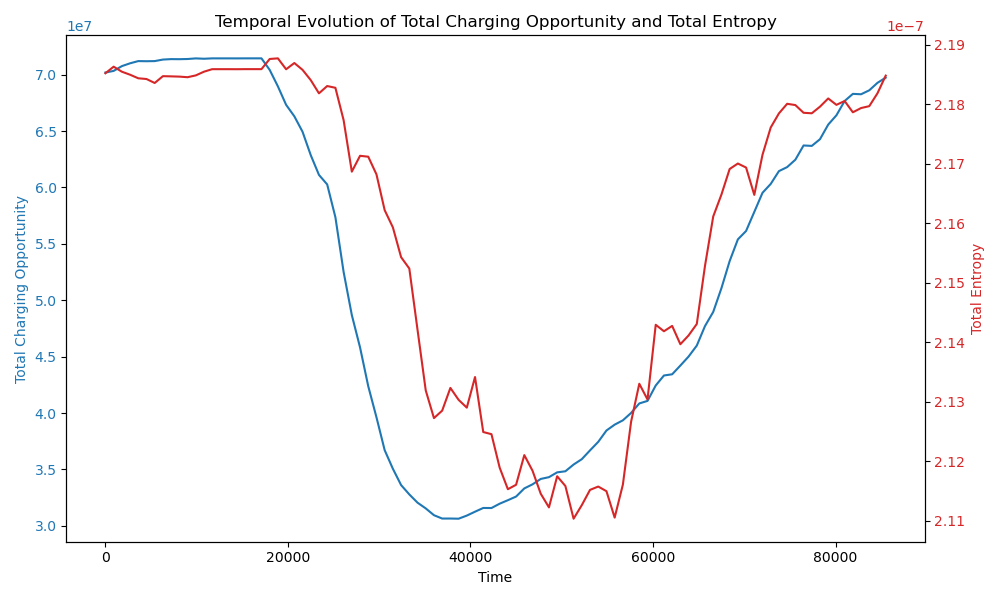

In [31]:
total_entropy_list = []
total_opportunity_list = []
time_labels = []

for time in elecCarTrace['Bin Label'].sort_values().unique():
    
    print('Time', time)
    time_labels.append(time) 
    
    subdf = elecCarTrace.loc[elecCarTrace['Bin Label'] == time]
    
    result_gdf = subdf.groupby(['geoid']).agg(
        {'Charging Opportunity': 'sum', 
        'geometry': 'first', 
        }    ).reset_index()
    
    result_gdf = gpd.GeoDataFrame(result_gdf, geometry='geometry')
    
    totalChargingOpportunity = subdf['Charging Opportunity'].sum()
    print('Total Charging Opportunity', totalChargingOpportunity)
    total_opportunity_list.append(totalChargingOpportunity)
    
    #Calculate Entropy of charging opportunity density
    result_gdf['Density Charging Opportunity'] = result_gdf['Charging Opportunity'].div(result_gdf.geometry.area)
    totalJunk = result_gdf['Density Charging Opportunity'].sum()
    result_gdf['Probability'] = result_gdf['Density Charging Opportunity'] / totalJunk
    result_gdf['Entropy'] = -result_gdf['Probability'] * np.log(result_gdf['Probability'])
    
    totalEntropy = result_gdf['Entropy'].sum()
    totalEntropyDensity = np.divide(totalEntropy,(5000*5000))
    print('Total Entropy', totalEntropy)
    print('Total Entropy Density', totalEntropyDensity)
    total_entropy_list.append(totalEntropyDensity)

    #entropyPlot5(result_gdf)    

#Plot Entropy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total charging opportunity on the first axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Total Charging Opportunity', color='tab:blue')
ax1.plot(time_labels, total_opportunity_list, label='Total Charging Opportunity', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for the total entropy
ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
ax2.set_ylabel('Total Entropy', color='tab:red')
ax2.plot(time_labels, total_entropy_list, label='Total Entropy', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title and display the plot
plt.title('Temporal Evolution of Total Charging Opportunity and Total Entropy')
fig.tight_layout()  # To prevent overlap of labels
plt.savefig(mainDirectory + 'timeEvolution.png', dpi = 100)
plt.show()

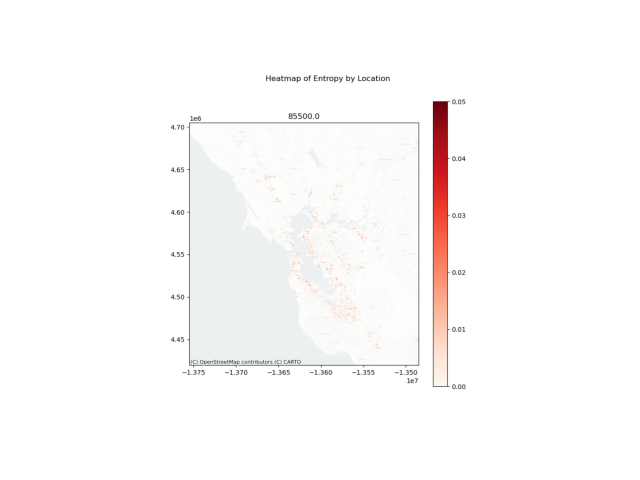

In [8]:
image_dir = 'images'
#image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]
image_files = [os.path.join(mainDirectory+image_dir, f) for f in os.listdir(mainDirectory+image_dir) if f.endswith('.png')]
image_files = sorted(image_files, key=os.path.getmtime, reverse=False)

fig, ax = plt.subplots()
# Function to update the plot for each frame
def animate(i):
    ax.clear()
    image = plt.imread(image_files[i])
    ax.set_axis_off()
    ax.imshow(image, extent = None)

# Create the animation
ani = FuncAnimation(fig, animate, frames=len(image_files), interval=200)

# Save the animation
ani.save(mainDirectory + '/animation.gif', writer='pillow')

## Multi-run Plots

In [21]:
#Could potentially be more depending on grid sizes and bin lengths, but these capture the extremes
zoneScenarios = [zoningFilepath1,zoningFilepath2,zoningFilepath3,zoningFilepath4] #paths to different grid sizes
gridSizes = [500,1000,5000,10000] #Labels for now, but could replace zoneScenarios
binLengths = [600,900,1800,3600,7200] #Different bin sizes

C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\843209929.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ect = pd.read_csv(mainDirectory + 'csvFiles\\ectBin' + str(case) + 'Grid' + str(size) + '.csv')


DataFrame created
Bin completed


C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\843209929.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ect = pd.read_csv(mainDirectory + 'csvFiles\\ectBin' + str(case) + 'Grid' + str(size) + '.csv')


DataFrame created
Bin completed
DataFrame created
Bin completed
DataFrame created
Bin completed
DataFrame created
Bin completed
About to plot


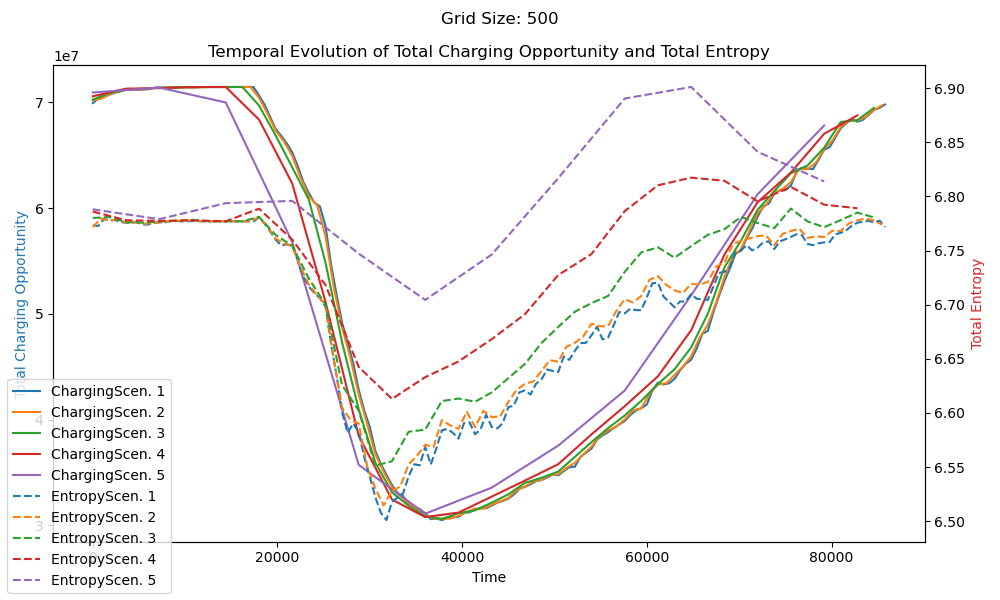

C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\843209929.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ect = pd.read_csv(mainDirectory + 'csvFiles\\ectBin' + str(case) + 'Grid' + str(size) + '.csv')


DataFrame created
Bin completed


C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\843209929.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ect = pd.read_csv(mainDirectory + 'csvFiles\\ectBin' + str(case) + 'Grid' + str(size) + '.csv')


DataFrame created
Bin completed
DataFrame created
Bin completed
DataFrame created
Bin completed
DataFrame created
Bin completed
About to plot


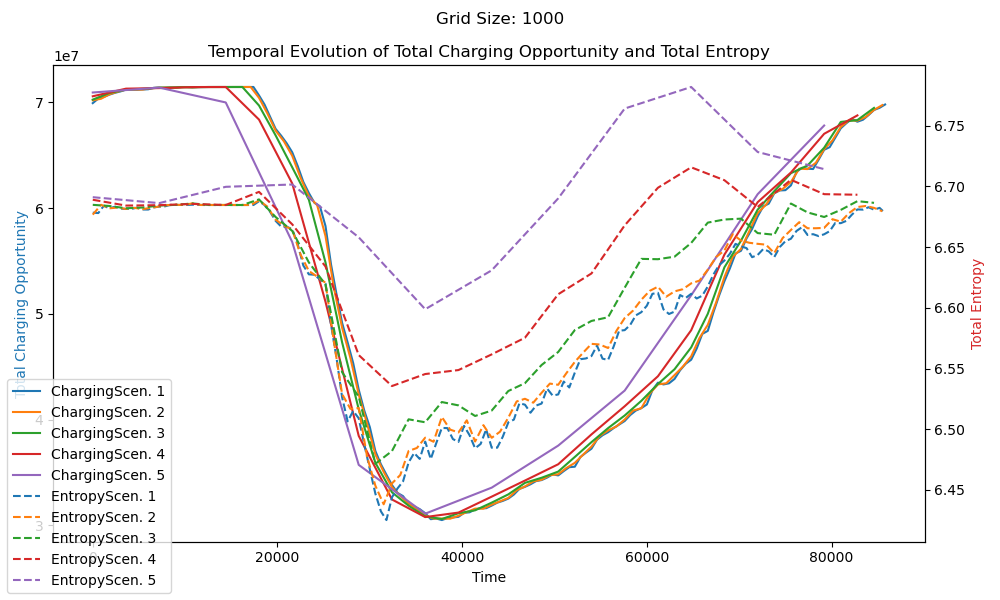

C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\843209929.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ect = pd.read_csv(mainDirectory + 'csvFiles\\ectBin' + str(case) + 'Grid' + str(size) + '.csv')


DataFrame created
Bin completed


C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\843209929.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ect = pd.read_csv(mainDirectory + 'csvFiles\\ectBin' + str(case) + 'Grid' + str(size) + '.csv')


DataFrame created
Bin completed
DataFrame created
Bin completed
DataFrame created
Bin completed
DataFrame created
Bin completed
About to plot


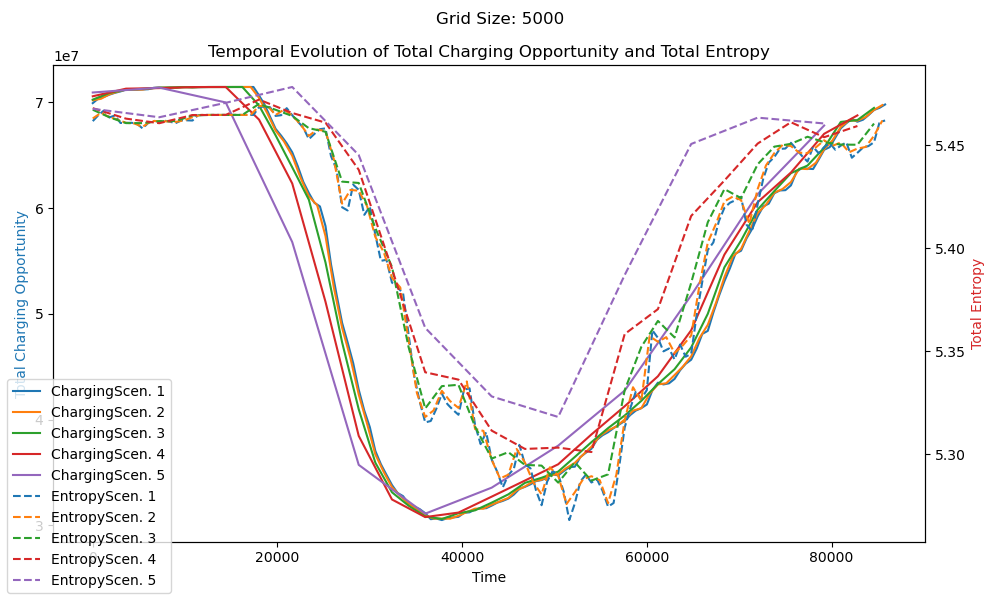

C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\843209929.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ect = pd.read_csv(mainDirectory + 'csvFiles\\ectBin' + str(case) + 'Grid' + str(size) + '.csv')


DataFrame created
Bin completed


C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\843209929.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ect = pd.read_csv(mainDirectory + 'csvFiles\\ectBin' + str(case) + 'Grid' + str(size) + '.csv')


DataFrame created
Bin completed
DataFrame created
Bin completed
DataFrame created
Bin completed
DataFrame created
Bin completed
About to plot


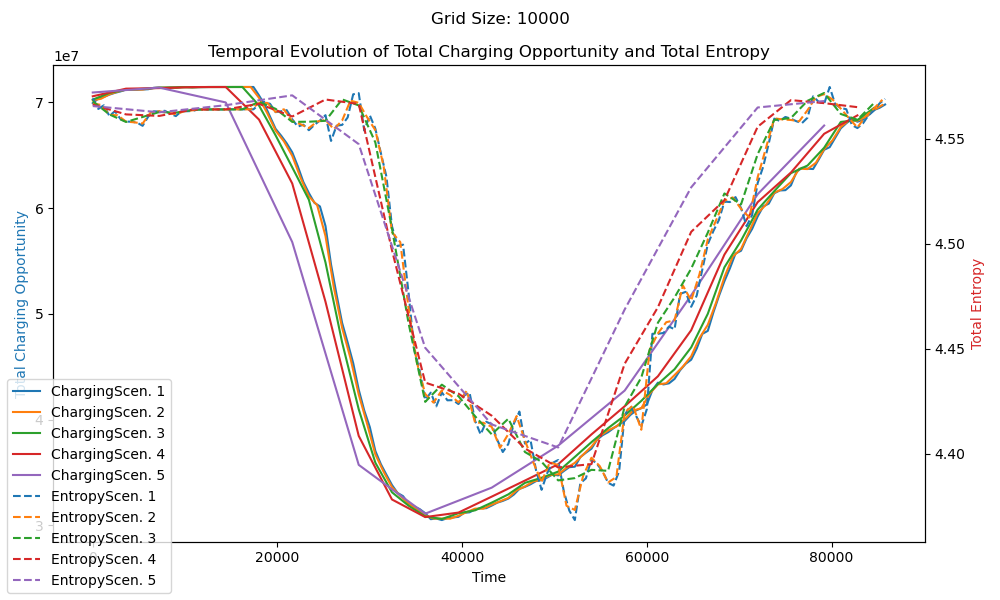

In [60]:
for zone,size in zip(zoneScenarios,gridSizes):
    entropyResults = []
    opportunityResults = []
    labels = []
    for case in binLengths:
        #ect = scenarioCreator(case,zone)
        ect = pd.read_csv(mainDirectory + 'csvFiles\\ectBin' + str(case) + 'Grid' + str(size) + '.csv')
        geo = gpd.GeoSeries.from_wkt(ect['geometry'])
        ect.drop(columns = 'geometry', inplace = True)
        ect = gpd.GeoDataFrame(ect, geometry = geo)
        print("DataFrame created")
        total_entropy_list = []
        total_opportunity_list = []
        time_labels = []

        for time in ect['Bin Label'].sort_values().unique():
    
            #print('Time', time)
            time_labels.append(time) 
    
            subdf = ect.loc[ect['Bin Label'] == time]
    
            result_gdf = subdf.groupby(['geoid']).agg(
                {'Charging Opportunity': 'sum', 
                'geometry': 'first', 
                }    ).reset_index()
    
            result_gdf = gpd.GeoDataFrame(result_gdf, geometry='geometry')
    
            totalChargingOpportunity = subdf['Charging Opportunity'].sum()
            #print('Total Charging Opportunity', totalChargingOpportunity)
            total_opportunity_list.append(totalChargingOpportunity)
    
            #Calculate Entropy of charging opportunity density
            result_gdf['Density Charging Opportunity'] = result_gdf['Charging Opportunity'].div(result_gdf.geometry.area)
            totalJunk = result_gdf['Density Charging Opportunity'].sum()
            result_gdf['Probability'] = result_gdf['Density Charging Opportunity'] / totalJunk
            result_gdf['Entropy'] = -result_gdf['Probability'] * np.log(result_gdf['Probability'])
    
            totalEntropy = result_gdf['Entropy'].sum()
            #print('Total Entropy', totalEntropy)
            total_entropy_list.append(totalEntropy)
        print('Bin completed')
        entropyResults.append(total_entropy_list)
        opportunityResults.append(total_opportunity_list)
        labels.append(time_labels)
    name = 'Grid Size: ' + str(size)
    print('About to plot')
    entropyPlot6(name)
    

C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\66375018.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ect = pd.read_csv(mainDirectory + 'csvFiles\\ectBin' + str(case) + 'Grid' + str(size) + '.csv')
C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\66375018.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ect = pd.read_csv(mainDirectory + 'csvFiles\\ectBin' + str(case) + 'Grid' + str(size) + '.csv')
C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\66375018.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ect = pd.read_csv(mainDirectory + 'csvFiles\\ectBin' + str(case) + 'Grid' + str(size) + '.csv')
C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\66375018.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ect = pd.read_csv(mainDirectory 

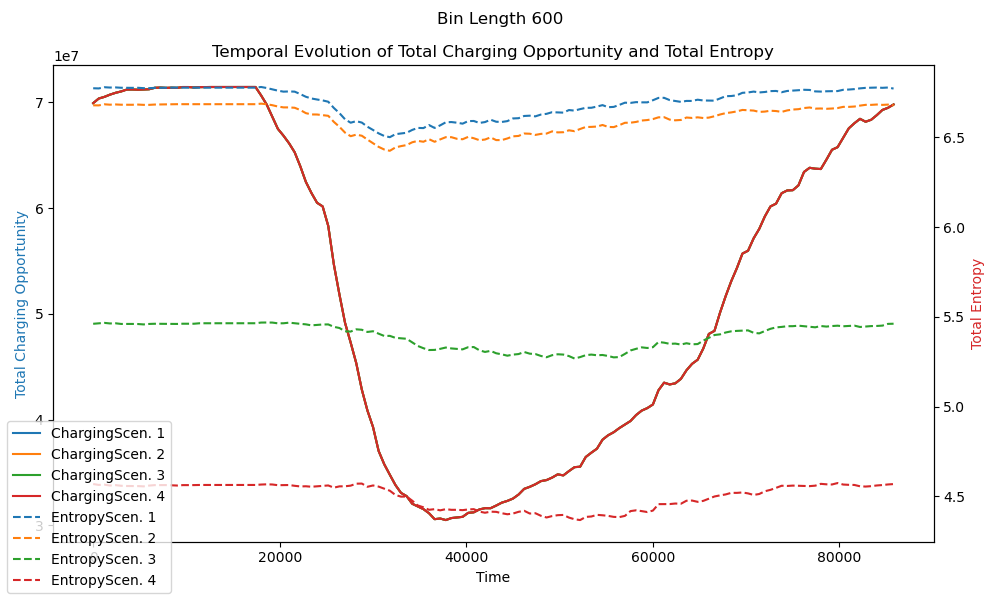

C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\66375018.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ect = pd.read_csv(mainDirectory + 'csvFiles\\ectBin' + str(case) + 'Grid' + str(size) + '.csv')
C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\66375018.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ect = pd.read_csv(mainDirectory + 'csvFiles\\ectBin' + str(case) + 'Grid' + str(size) + '.csv')
C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\66375018.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ect = pd.read_csv(mainDirectory + 'csvFiles\\ectBin' + str(case) + 'Grid' + str(size) + '.csv')
C:\Users\jmckinney\AppData\Local\Temp\ipykernel_4316\66375018.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ect = pd.read_csv(mainDirectory 

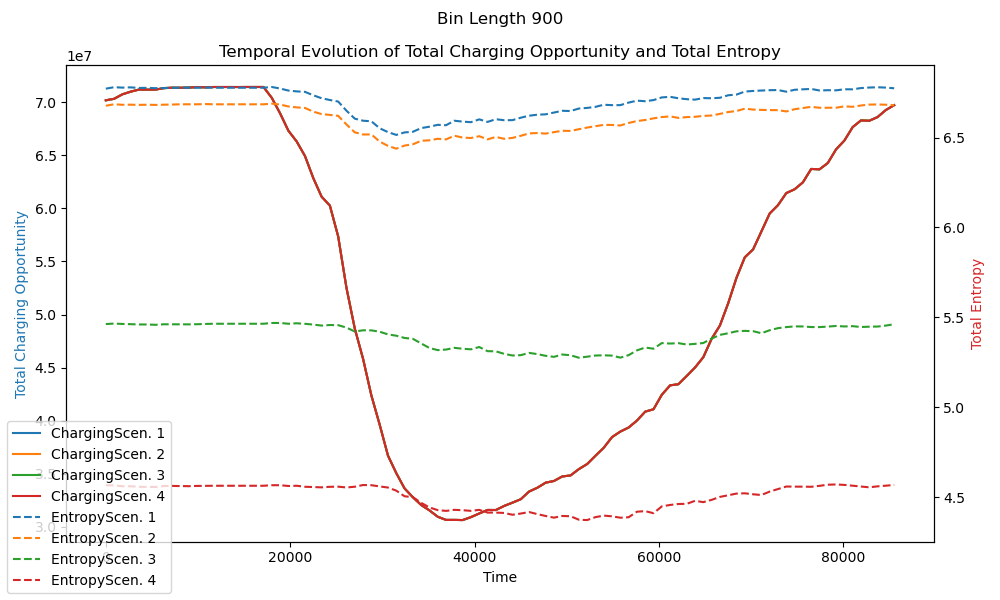

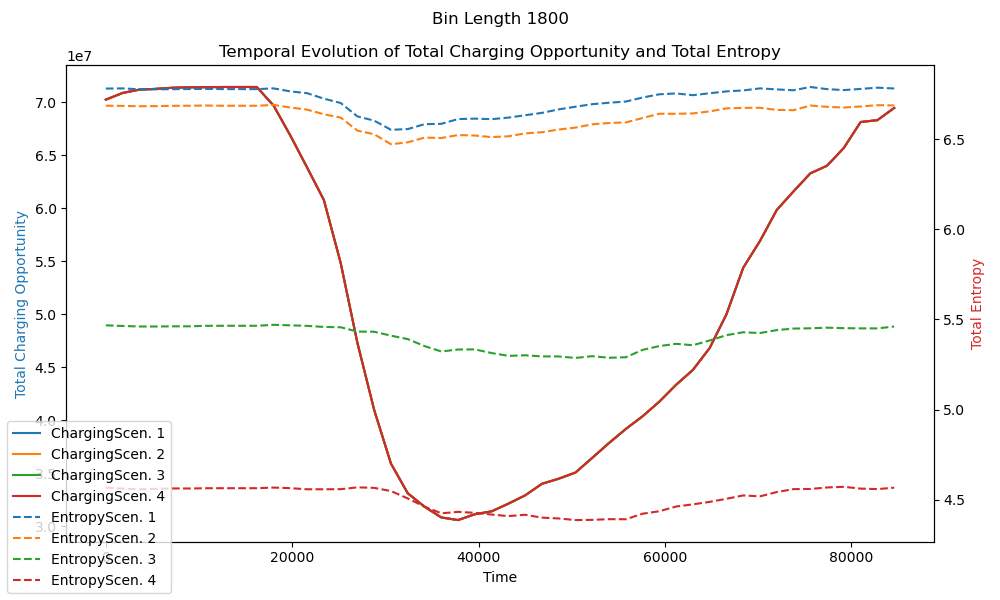

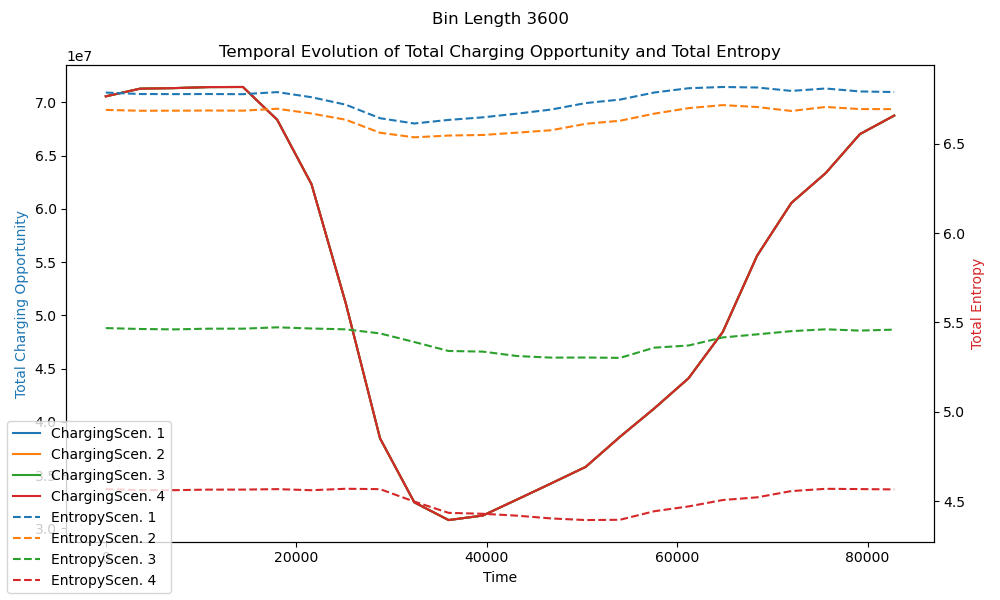

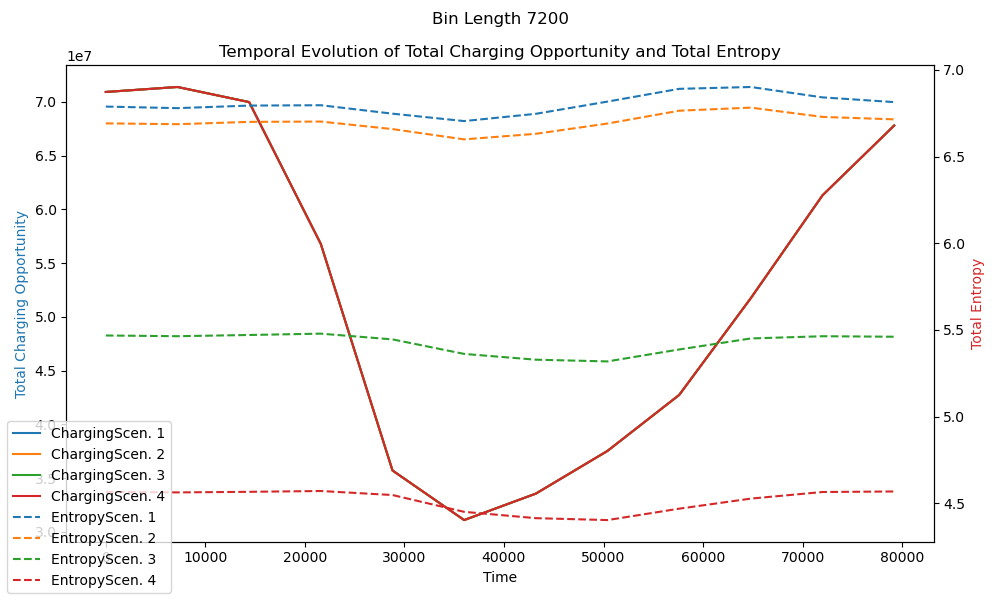

In [62]:
#JM Theoretically this should produce some different looking plots, but there's something wrong with grid normalization
for case in binLengths:
    entropyResults = []
    opportunityResults = []
    labels = []
    for zone,size in zip(zoneScenarios,gridSizes):
        #ect = scenarioCreator(case,grids)
        ect = pd.read_csv(mainDirectory + 'csvFiles\\ectBin' + str(case) + 'Grid' + str(size) + '.csv')
        geo = gpd.GeoSeries.from_wkt(ect['geometry'])
        ect.drop(columns = 'geometry', inplace = True)
        ect = gpd.GeoDataFrame(ect, geometry = geo)

        total_entropy_list = []
        total_opportunity_list = []
        time_labels = []

        for time in ect['Bin Label'].sort_values().unique():
    
            #print('Time', time)
            time_labels.append(time) 
    
            subdf = ect.loc[ect['Bin Label'] == time]
    
            result_gdf = subdf.groupby(['geoid']).agg(
                {'Charging Opportunity': 'sum', 
                'geometry': 'first', 
                }    ).reset_index()
    
            result_gdf = gpd.GeoDataFrame(result_gdf, geometry='geometry')
    
            totalChargingOpportunity = subdf['Charging Opportunity'].sum()
            #print('Total Charging Opportunity', totalChargingOpportunity)
            total_opportunity_list.append(totalChargingOpportunity)
    
            #Calculate Entropy of charging opportunity density
            result_gdf['Density Charging Opportunity'] = result_gdf['Charging Opportunity'].div(result_gdf.geometry.area)
            totalJunk = result_gdf['Density Charging Opportunity'].sum()
            result_gdf['Probability'] = result_gdf['Density Charging Opportunity'] / totalJunk
            result_gdf['Entropy'] = -result_gdf['Probability'] * np.log(result_gdf['Probability'])
    
            totalEntropy = result_gdf['Entropy'].sum()
            #print('Total Entropy', totalEntropy)
            total_entropy_list.append(totalEntropy)
        entropyResults.append(total_entropy_list)
        opportunityResults.append(total_opportunity_list)
        labels.append(time_labels)
    name = 'Bin Length ' + str(case)
    entropyPlot6(name)